

"CT scans plays a supportive role in the diagnosis of COVID-19 and is a key procedure for determining the severity that the patient finds himself in.
Models that can find evidence of COVID-19 and/or characterize its findings can play a crucial role in optimizing diagnosis and treatment, especially in areas with a shortage of expert radiologists.
This dataset contains 20 CT scans of patients diagnosed with COVID-19 as well as segmentations of lungs and infections made by experts."

Desafio do Kaggle: https://www.kaggle.com/andrewmvd/covid19-ct-scans

\\

# **Importando arquivos do Kaggle para o Colab**

In [ ]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "kaggle_json_username" # username from the json file
os.environ['KAGGLE_KEY'] = "fdad8ab256e18aa4df58f629b48fb1ce" # key from the json file

!kaggle datasets download -d andrewmvd/covid19-ct-scans

 98% 1.02G/1.03G [00:43<00:00, 21.1MB/s]
100% 1.03G/1.03G [00:43<00:00, 25.6MB/s]


In [ ]:
!mkdir 'CT-Covid'

!unzip '/content/covid19-ct-scans.zip' -d '/content/CT-Covid'

Archive:  /content/covid19-ct-scans.zip
  inflating: /content/CT-Covid/ct_scans/coronacases_org_001.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_002.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_003.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_004.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_005.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_006.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_007.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_008.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_009.nii  
  inflating: /content/CT-Covid/ct_scans/coronacases_org_010.nii  
  inflating: /content/CT-Covid/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: /content/CT-Covid/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: /content/CT-Covid/ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating:

# **CT Scan: Getting Started**

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import time
import psutil
import cv2
import os
import h5py

A fim de facilitar a leitura dos arquivo dos exames, o caminho de cada exame está salvo no arquivo: `metadata.csv`

In [ ]:
# Author: Larxel
# https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

# Read and examine metadata
raw_data = pd.read_csv('/content/CT-Covid/metadata.csv')
raw_data.shape[0]

20

Alterando ID do diretório de '../input/covid19-ct-scans/' para '/content/CT-Covid/':

In [ ]:
print(list(raw_data))

for i in list(raw_data):
  raw_data[i] = raw_data[i].str.replace('../input/covid19-ct-scans/','/content/CT-Covid/')

raw_data.sample(5)

['ct_scan', 'lung_mask', 'infection_mask', 'lung_and_infection_mask']


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
3,/content/CT-Covid/ct_scans/coronacases_org_004...,/content/CT-Covid/lung_mask/coronacases_004.nii,/content/CT-Covid/infection_mask/coronacases_0...,/content/CT-Covid/lung_and_infection_mask/coro...
17,/content/CT-Covid/ct_scans/radiopaedia_org_cov...,/content/CT-Covid/lung_mask/radiopaedia_40_866...,/content/CT-Covid/infection_mask/radiopaedia_4...,/content/CT-Covid/lung_and_infection_mask/radi...
16,/content/CT-Covid/ct_scans/radiopaedia_org_cov...,/content/CT-Covid/lung_mask/radiopaedia_36_865...,/content/CT-Covid/infection_mask/radiopaedia_3...,/content/CT-Covid/lung_and_infection_mask/radi...
9,/content/CT-Covid/ct_scans/coronacases_org_010...,/content/CT-Covid/lung_mask/coronacases_010.nii,/content/CT-Covid/infection_mask/coronacases_0...,/content/CT-Covid/lung_and_infection_mask/coro...
4,/content/CT-Covid/ct_scans/coronacases_org_005...,/content/CT-Covid/lung_mask/coronacases_005.nii,/content/CT-Covid/infection_mask/coronacases_0...,/content/CT-Covid/lung_and_infection_mask/coro...


# **Lendo e Visualizando Arquivos**

Os arquivos fornecidos estão no formato NifTi (\*.nii), portanto usamos a biblioteca *nibabel* a fim de importá-los para o formato de array:

In [ ]:
# Author: Larxel
# https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))

    return array

Extraindo as imagens e máscaras de um dos exames:

In [ ]:
# Author: Larxel
# https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

# read sample
sample_ct   = read_nii(raw_data.loc[0,'ct_scan'])
sample_lung = read_nii(raw_data.loc[0,'lung_mask'])
sample_infe = read_nii(raw_data.loc[0,'infection_mask'])
sample_all  = read_nii(raw_data.loc[0,'lung_and_infection_mask'])

Definindo função para visualizar os exames e máscaras:

In [ ]:
# Author: Larxel
# https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung + Infection Mask')

    plt.show()

    return

Plotando uma das camadas do exame **coronacases_org_001**. São apresentadas as imagens original e com as máscaras:

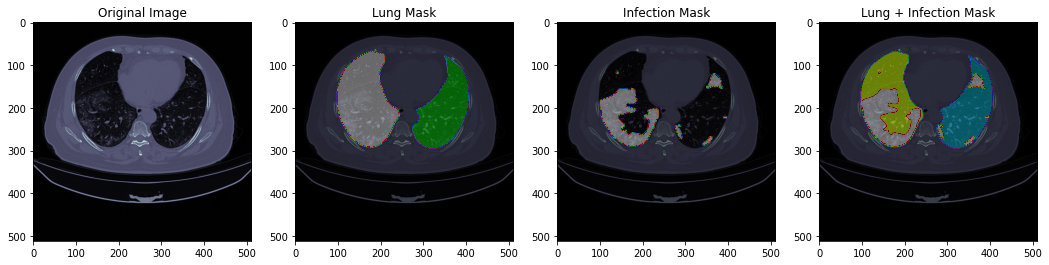

In [ ]:
# Author: Larxel
# https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])


Visualizando o tamanho e o número de imagens por exame:

In [ ]:
for i in range(raw_data.shape[0]):
  ct = read_nii(raw_data['ct_scan'][i])
  print(f'{i+1} {ct.shape}')

1 (512, 512, 301)
2 (512, 512, 200)
3 (512, 512, 200)
4 (512, 512, 270)
5 (512, 512, 290)
6 (512, 512, 213)
7 (512, 512, 249)
8 (512, 512, 301)
9 (512, 512, 256)
10 (512, 512, 301)
11 (630, 630, 39)
12 (630, 630, 418)
13 (401, 630, 110)
14 (630, 630, 66)
15 (630, 630, 42)
16 (630, 630, 42)
17 (630, 630, 45)
18 (630, 630, 93)
19 (630, 630, 39)
20 (630, 630, 45)


# **Pré-Processamento**
## **Processamento das Imagens**

Os 10 exames providos pelo *Radiopedia* foram ajustados para uma janela pulmonar, em Hounsfield, entre [-1250,250], e em seguida os pixels foram ajustados para valores entre [0,255]. A fim de padronizar os dados, o mesmo deverá ser feito com os 10 exames providos pelo *Coronacases*¹. Primeiro, a janela de pixels deve ser ajustada para valores entre [-1250,250]²³ e em seguida para valores entre [0,255].

\\
¹ https://gitee.com/junma11/COVID-19-CT-Seg-Benchmark

² https://www.radiologycafe.com/medical-students/radiology-basics/ct-overview

³ https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography

\\

 A função a seguir efetua essas conversões:


In [ ]:
# Adjusting lung window then converting byte format, 8-bit values

def lung_window(image):
  img = image.copy()
  clip = np.clip(img, -1250, 250)         # Adjusting lung window
  
  return (clip*255.0/1500.0)+212.5        # Changing from Hounsfield to [0,255]

Comparando imagens de antes e após o ajuste:

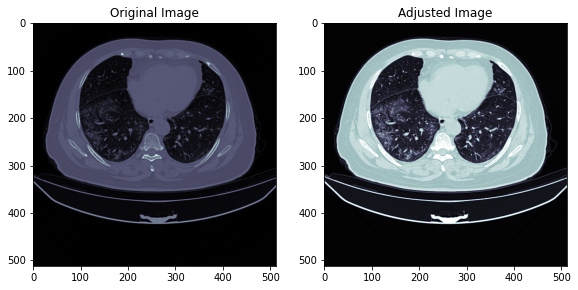

In [ ]:
img_1 = sample_ct[...,120]
img_2 = lung_window(sample_ct[...,120])

fig = plt.figure(figsize=(20,15))

# Image without adjust
plt.subplot(1,4,1)
plt.imshow(img_1, cmap='bone')
plt.title('Original Image')

# Adjusted image
plt.subplot(1,4,2)
plt.imshow(img_2, cmap='bone')
plt.title('Adjusted Image')

plt.show()

Histograma de brilho das imagens:

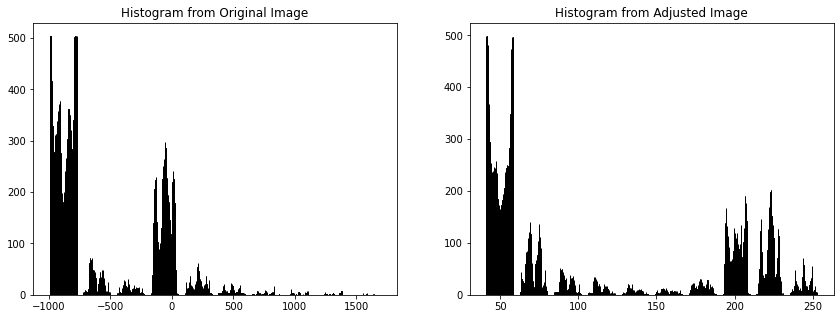

In [ ]:
fig = plt.figure(figsize=(30,5))

# Image without adjust
plt.subplot(1,4,1)
plt.hist(img_1,fc='k', ec='k')
plt.title('Histogram from Original Image')

# Adjusted image
plt.subplot(1,4,2)
plt.hist(img_2,fc='k', ec='k')
plt.title('Histogram from Adjusted Image')

plt.show()



O processo a seguir implementa o ajuste mencionado para todos os exames do *Coronacases*, além do reajuste do tamanho de todas as imagens para 128x128 pixels e normalização dos pixels para valores entre [0,1]:

In [ ]:
start_time = time.time()
process = psutil.Process(os.getpid())
'----------------------------------------------------------------------------------------------------'

ct_images = []

size = (128,128)

# Adjusting lung window for "coronacases" exams
for i in list(raw_data['ct_scan'][0:10]):
  ct = read_nii(i) # Getting exam

  for k in range(int(ct.shape[2])):
    ct_scan = lung_window(ct[...,k]) # Getting single slice and adjuting lung window
    ct_resize =  cv2.resize(ct_scan, dsize = size)  # Resizing
    max = ct_resize.max() # Getting maximum pixel value

    if max > 0:
      ct_images.append(ct_resize/max) # Appending resized and normalized image
    else:
      ct_images.append(ct_resize) # In case of a null image matrix


for i in list(raw_data['ct_scan'][10:20]):
  ct = read_nii(i)  # Getting exam

  for k in np.arange(int(ct.shape[2])):
    ct_scan = ct[...,k] # Getting single slice
    ct_resize =  cv2.resize(ct_scan, dsize = size)  # Resizing
    max = ct_resize.max() # Getting maximum pixel value

    if max > 0:
      ct_images.append(ct_resize/max) # Appending resized and normalized image
    else:
      ct_images.append(ct_resize) # In case of a null image matrix

'----------------------------------------------------------------------------------------------------'     
print('\n--- memory use ---\n{:0.2f} GB'.format(process.memory_info().rss/1000000000))  # in Gbytes 
print('\n--- time ---\n{:0.2f} min'.format(((time.time() - start_time))/60))


--- memory use ---
7.36 GB

--- time ---
0.22 min


Reajustando o tamanho das máscaras e normalizando os valores de pixel:

In [ ]:
start_time = time.time()
process = psutil.Process(os.getpid())
'----------------------------------------------------------------------------------------------------'

lung_mask = []

size = (128,128)

for i in list(raw_data['lung_mask'][0:20]):
  lung = read_nii(i)  # Getting exam

  for k in range(int(lung.shape[2])):
    lung_seg = lung[...,k]  # Getting single slice
    lung_resize = cv2.resize(lung_seg, dsize = size)  # Resizing
    max = lung_resize.max() # Getting maximum pixel value

    if max > 0:
      lung_mask.append(lung_resize/max) # Appending resized and normalized image
    else:
      lung_mask.append(lung_resize) # In case of a null image matrix  

'----------------------------------------------------------------------------------------------------'
print('\n--- memory use ---\n{:0.2f} GB'.format(process.memory_info().rss/1000000000))  # in Gbytes 
print('\n--- time ---\n{:0.2f} min'.format(((time.time() - start_time))/60))


--- memory use ---
6.98 GB

--- time ---
0.73 min


In [ ]:
start_time = time.time()
process = psutil.Process(os.getpid())
'----------------------------------------------------------------------------------------------------'

infection_mask = []

size = (128,128)

for i in list(raw_data['infection_mask'][0:20]):
  infec = read_nii(i)  # Getting exam

  for k in range(int(infec.shape[2])):
    infec_seg = infec[...,k]  # Getting single slice
    infec_resize = cv2.resize(infec_seg, dsize = size)  # Resizing
    max = infec_resize.max() # Getting maximum pixel value

    if max > 0:
      infection_mask.append(infec_resize/max) # Appending resized and normalized image
    else:
      infection_mask.append(infec_resize) # In case of a null image matrix  

'----------------------------------------------------------------------------------------------------'
print('\n--- memory use ---\n{:0.2f} GB'.format(process.memory_info().rss/1000000000))  # in Gbytes 
print('\n--- time ---\n{:0.2f} min'.format(((time.time() - start_time))/60))


--- memory use ---
8.31 GB

--- time ---
0.74 min


In [ ]:
max_ct = []
min_ct = []
for i in range(len(ct_images)):
  max_ct.append(ct_images[i].max())
  min_ct.append(ct_images[i].min())
print(f'Os valores de pixel para as imagens originais estão normalizados entre:\n ({np.array(min_ct).min()},{np.array(max_ct).max()})\n')

max_lung = []
min_lung = []
for i in range(len(lung_mask)):
  max_lung.append(lung_mask[i].max())
  min_lung.append(lung_mask[i].min())
print(f'Os valores de pixel para as máscaras do pulmão estão normalizados entre:\n ({np.array(min_lung).min()},{np.array(max_lung).max()})')

max_inf = []
min_inf = []
for i in range(len(infection_mask)):
  max_inf.append(infection_mask[i].max())
  min_inf.append(infection_mask[i].min())
print(f'Os valores de pixel para as máscaras de infecção estão normalizados entre:\n ({np.array(min_inf).min()},{np.array(max_inf).max()})')

Os valores de pixel para as imagens originais estão normalizados entre:
 (0.0,1.0)

Os valores de pixel para as máscaras do pulmão estão normalizados entre:
 (0.0,1.0)
Os valores de pixel para as máscaras de infecção estão normalizados entre:
 (0.0,1.0)


Verificando se todos os tamanhos das imagens foram reajustados para 128x128 pixels:

In [ ]:
shape_ct = []

for i in ct_images:
  if i.shape != (128,128):
    shape_ct.append(i)

if len(shape_ct) == 0:
  print('Todas as imagens originais foram reajustadas para 128x128 pixels\n')
else:
  print('Ainda há imagens não reajustadas\n')

shape_lung = []

for i in lung_mask:
  if i.shape != (128,128):
    shape_lung.append(i)

if len(shape_lung) == 0:
  print('Todas as máscaras do pulmão foram reajustadas para 128x128 pixels')
else:
  print('Ainda há máscaras (pulmão) a serem reajustadas não reajustadas')

shape_infec = []

for i in infection_mask:
  if i.shape != (128,128):
    shape_infec.append(i)

if len(shape_infec) == 0:
  print('Todas as máscaras do pulmão foram reajustadas para 128x128 pixels')
else:
  print('Ainda há máscaras (pulmão) a serem reajustadas não reajustadas')

Todas as imagens originais foram reajustadas para 128x128 pixels

Todas as máscaras do pulmão foram reajustadas para 128x128 pixels
Todas as máscaras do pulmão foram reajustadas para 128x128 pixels


## **Salvando as imagens em HDF5**

A fim de poupar tempo de processamento, as imagens dos exames e das máscaras serão salvos em um arquivo *.HDF5 para serem utilizadas no pré-processamento prévio ao treino:

In [ ]:
with h5py.File('/content/drive/MyDrive/1-Projeto_Final_DL/Covid_Resized.h5','w') as h5f:
  h5f.create_dataset("Resized_Images/ct_scan", data=ct_images, compression="lzf", chunks=(True))
  h5f.create_dataset("Resized_Images/lung_mask", data=lung_mask, compression="lzf", chunks=True)
  h5f.create_dataset("Resized_Images/infection_mask", data=infection_mask, compression="lzf", chunks=True)
h5f.close()